## Implementation of ECGNet


##### Other useful papers:
https://arxiv.org/pdf/1707.01836.pdf

https://github.com/awni/ecg/


In [ ]:
%set_env TF_FORCE_GPU_ALLOW_GROWTH=true
import pandas as pd
import numpy as np
import os
import re
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import Normalizer, OneHotEncoder

In [ ]:
def preprocess_dataframe(df):
    
    '''
        Reads & preprocess dataframe w/ 3 labels: time, signal, label
    '''
    
    #df = df.iloc[:, 1:] # use system time - keep for DenoisedNormalizedData set
    df.columns = ['time','signal_val','label'] # set labels
    df = df.loc[df.time.notnull()].copy() # getting only not null values
    #df.time = (df.time * 1000).astype('int') #- keep for DenoisedNormalizedData set
    
    df = df.iloc[1:,:] # removes first row of labels
    
    df["label"] = df["label"].astype('str').astype('int')
    df["time"] = df["time"].astype('str').astype('int')
    df["signal_val"] = df["signal_val"].astype('str').astype('double')
    #df.label = df.label.astype('int') # labels as int - keep for DenoisedNormalizedData set
    
    return df

In [ ]:
def import_train_test_data(data_dir, test_user=None):
    
    '''
        See here for more info:
        https://github.com/atabas/Heartbeat-Classification/blob/master/ImageConversion.ipynb
    '''
    
    train = pd.DataFrame([], columns=['time', 'signal_val', 'label'])    # train dataset
    test = pd.DataFrame([], columns=['time', 'signal_val', 'label'])     # test dataset
    #sumat = 0
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            
            df = pd.read_csv(data_dir + '/' + filename, header=None)
            df = preprocess_dataframe(df)

            user_num = int(re.findall(r'\d+',filename.split('_')[0])[0]) #get user number
            
            # Check if ignore_user
            if (user_num != test_user):
                train = train.append(df)
            else:
                test = test.append(df)
 
    return train, test

In [ ]:
# Data preprocessing: L2 Normalization

In [ ]:
# Model (original from paper):
# Input: 720 samples
# Output: 3 classes
# Loss: cross-entropy
# Training: SGD, LR=0.01, momentum=0.9, minibatch=8, epochs=50
# res blocks: 64*k conv filters, where k = 1 and increased every 4th res block

##### ECGNet Architecture
https://ieeexplore.ieee.org/document/8438739

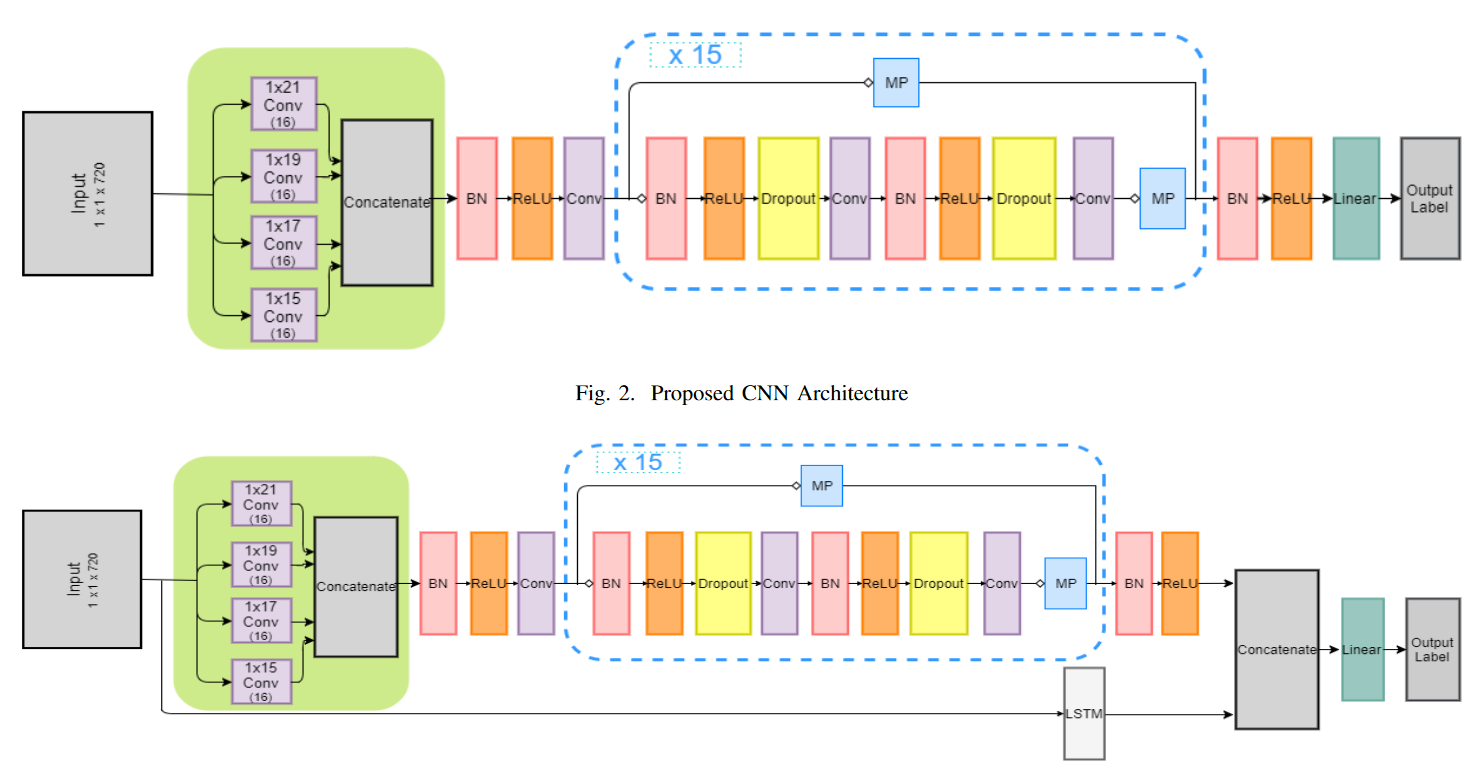

In [ ]:
def _resBlock(input_layer, n_filters, dropout_rate=0.2):
    
    # Convolutional path
    bn1 = layers.BatchNormalization()(input_layer)
    relu1 = layers.ReLU()(bn1)
    drop1 = layers.Dropout(rate=dropout_rate)(relu1)
    conv1 = layers.Conv1D(filters=n_filters, kernel_size=17)(drop1)
    
    bn2 = layers.BatchNormalization()(conv1)
    relu2 = layers.ReLU()(bn2)
    drop2 = layers.Dropout(rate=dropout_rate)(relu2)
    conv2 = layers.Conv1D(filters=n_filters, kernel_size=17)(drop2)
    mp = layers.MaxPooling1D(pool_size=2, stride=2)(conv2)
    
    # Residual path
    shortcut = layers.MaxPooling1D(pool_size=2, strides=2)(input_layer)
    
    # Combining the two paths (adding)
    output = layers.Add()([shortcut, mp])
    
    return output

In [ ]:
def ecgnet(input_shape=(720,), output_shape=(720, 3)):
    
    input_layer = layers.Input(shape=input_shape)
    
    # ======= RNN (LSTM) =======
    # TO CHECK: 12 timesteps each having 60 samples; output vector of size 40
    lstm = layers.LSTM(units=40) 
    
    # ======= Residual Conv Net =======
    # Head: 4 parallel convolutional layers
    conv1 = layers.Conv1D(filters=16, kernel_size=21)(input_layer)
    conv2 = layers.Conv1D(filters=16, kernel_size=19)(input_layer)
    conv3 = layers.Conv1D(filters=16, kernel_size=17)(input_layer)
    conv4 = layers.Conv1D(filters=16, kernel_size=15)(input_layer)
    
    # concatenate 4 conv layers
    concat1 = layers.Concatenate(axis=1)([conv1, conv2, conv3, conv4]) # which axis?
    
    bn1 = layers.BatchNormalization()(concat1)
    relu1 = layers.ReLU()(bn1)
    resBlockInput = layers.Conv1D(filters=32, kernel_size=17)(relu1) # idk num filters or kernel size
    
    # Residual blocks (15)
    k = 1 # multiplier for number of Conv1D filters
    resBlockOutput = resBlockInput
    for i in range(1,16):
        # increase K for every 4th block
        if (k in [4, 8, 12]):
            k += 1
            
        resBlockOutput = _resBlock(resBlockOutput, 64*k)
    
    # BN + ReLU after residual blocks
    bn3 = layers.BatchNormalization()(resBlockOutput)
    relu3 = layers.ReLU(bn3)
    
    # ======== Concatenate LSTM with Residual Net ======
    concat2 = layers.Concat(axis=1)([relu3, lstm])
    
    # ======== Dense Net ==========
    # TODO
    output_layer = layers.Dense(720)(concat2)
    
    # ==== Create and compile model ====
    # Use SparseCatCrossEntr. to keep labels as integers (not one-hot)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    SGD = optimizers.SGD(learning_rate=0.01, momentum=0.9)
    
    model.compile(optimizer=SGD,
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model